In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Intro to Building and Deploying an Agent with Gemini

Features demonstrated

a) Gemini with Grounding with Google Search

b) Gemini with Vertex AI Search for RAG

b) Gemini with function calling with Extensions and API call

c) Gemini with Langchain Agent through Reasoning Engine , Extensions and API call

Google Cloud Products
- Vertex Reasoning Engine
- Vertex AI Extensions
- Vertex AI Search
- Gemini API

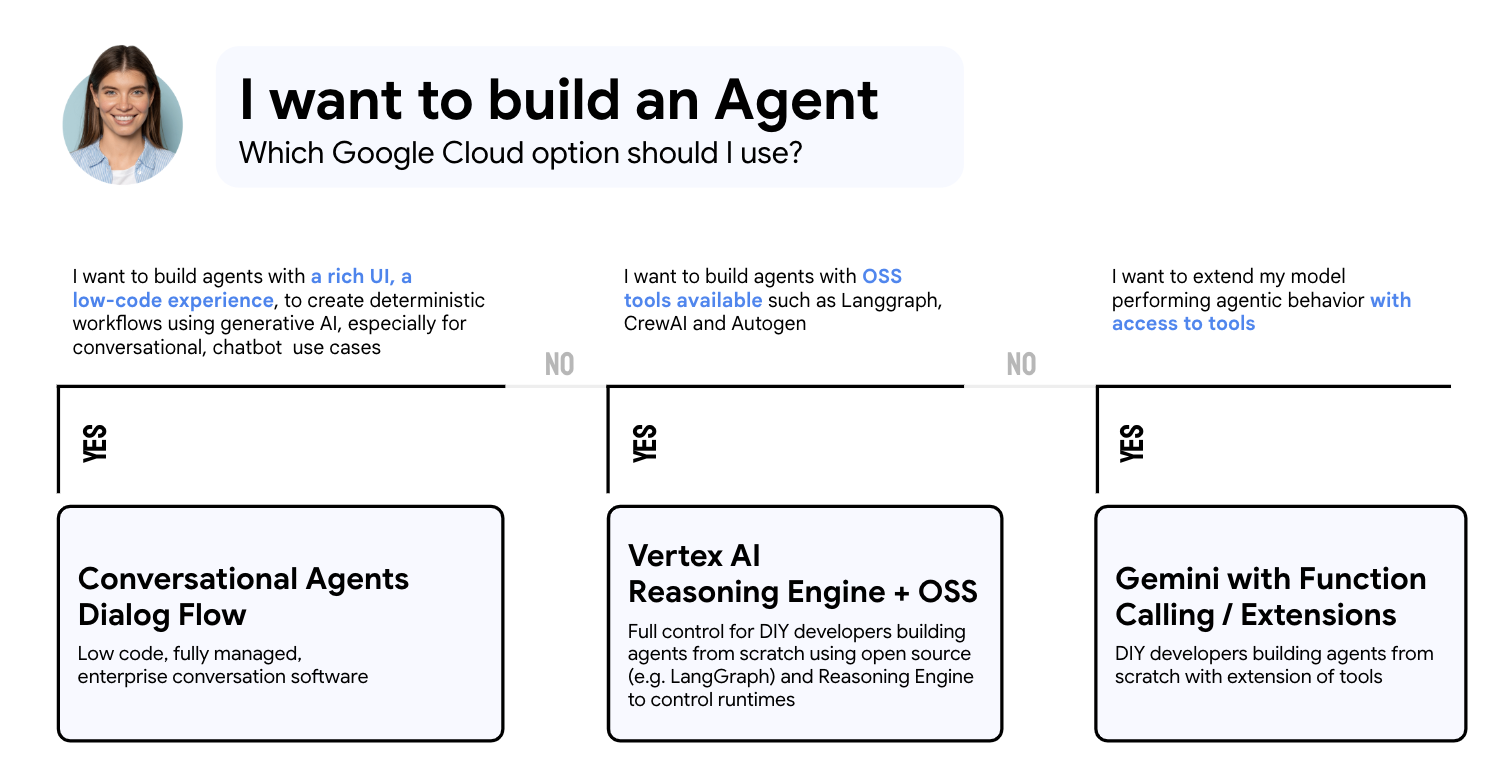

We will be discussing the multiple ways you can extend Gemini with really no Agentic frameworks, then will jump to Langchain

| | |
|-|-|
|Author(s) | [Kanchana Patlolla](https://linkedin.com/in/kanchanapatlolla) |

### Objectives

In this tutorial, you will learn how to build and deploy an agent (model, tools, and reasoning) using the Vertex AI SDK for Python.

You'll build and deploy an agent that uses the Gemini Pro model, Python functions as tools, Vertex AI Search for grounding and as an extension.



## Getting Started


### Install Vertex AI SDK for Python

Install the latest version of the Vertex AI SDK for Python as well as extra dependencies related to:

In [ ]:
!pip install --upgrade --quiet \
    "google-cloud-aiplatform[langchain,reasoningengine]" \

!pip show google-cloud-aiplatform

### Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>



### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).

In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK


In [ ]:
PROJECT_ID = ""  # @param {type:"string"}
LOCATION = ""  # @param {type:"string"}
STAGING_BUCKET = ""  # @param {type:"string"}

# prefix staging_bucket with gs://





In [ ]:
import vertexai
from vertexai.generative_models import (
    FunctionDeclaration,
    GenerativeModel,
    Tool,
    grounding,
)



from vertexai.preview.generative_models import grounding as preview_grounding


vertexai.init(project=PROJECT_ID, location=LOCATION, staging_bucket=STAGING_BUCKET)

## Example: Build and deploy an agent

### Import libraries

In [ ]:
from vertexai.preview import extensions

### Define model

Here we define what the model would do
You had system_instruction to emphasize the needs
generation_config you can [add](https://cloud.google.com/vertex-ai/generative-ai/docs/reference/python/latest/vertexai.generative_models.GenerationConfig) multiple values


In [ ]:
model = GenerativeModel(
    "gemini-1.5-flash",
    system_instruction=[
        """You are an assistant that helps me search things. Please be accurate. """
    ],
    generation_config={"temperature": 0.0},
      )


# Google Search as a Tool




Here we reference the tool (from_google_search_retrieval) and pass the prompt for generation of content



In [ ]:
PROMPT = "What is the capital of India"
google_search_tool = Tool.from_google_search_retrieval(grounding.GoogleSearchRetrieval())
response = model.generate_content(PROMPT, tools=[google_search_tool])
print(response.candidates[0].content)

# RAG with Vertex AI Search

Here we reference Vertex AI Search to pass a set of documents
and search the content

To execute the below you would need Search App id and Search App Region

Visit how to create Search data Store [here](https://cloud.google.com/generative-ai-app-builder/docs/try-enterprise-search#create_a_data_store)

Upload files you would like

In [ ]:
SEARCH_APP_REGION = "global"
SEARCH_APP_ID = ""  # @param {type:"string"}
PROMPT = "What is the operating income in 2024"


In [ ]:
vertex_search_tool = Tool.from_retrieval(
    preview_grounding.Retrieval(
        preview_grounding.VertexAISearch(
            datastore=SEARCH_APP_ID,
            project=PROJECT_ID,
            location=SEARCH_APP_REGION,
        )
    )
)

response = model.generate_content(PROMPT, tools=[vertex_search_tool])

print(response)

# Multiple Tools with Function calling

In this section, we attempt to show multiple functions can be defined as tools
Function 1: google_query_info -> Retrieves information from the Vertex AI Search part of the RAG
Function 2: get_exchange_rate -> calls the API to get current exchange information

Both functions are used as tools in one agent. Agent does the reasoning to call the specific functions

I create an extension to show case that you can leverage extensions from hub ([Overview](https://cloud.google.com/vertex-ai/generative-ai/docs/extensions/overview))

In [ ]:

# Construct an object that points to the relevant data store.
DATASTORE = f"projects/{PROJECT_ID}/locations/global/collections/default_collection/dataStores/{SEARCH_APP_ID}/servingConfigs/default_search"

# Instantiate extension.
extension_vertex_ai_search = extensions.Extension.from_hub(
    "vertex_ai_search",
    runtime_config={
        "vertex_ai_search_runtime_config": {
            "serving_config_name": DATASTORE,
        }
    })

extension_vertex_ai_search

In [ ]:
resource = extension_vertex_ai_search.resource_name

Here we define a simple python function, make it descriptive enough to understand what the input and output types are

In [ ]:
def google_query_info(query: str = "Who is the CEO",) -> str:
    """
    Queries quarterly reports from Alphabet using Vertex AI Search datastore.

    This function utilizes the Vertex AI Search extension to retrieve information
    from Alphabet's quarterly reports based on a provided natural language query.

    For example:

    ```python
    google_query_info(query="who is the CEO?")
    ```

    Args:
      query: The natural language query to be submitted to the Vertex Search extension.

    Returns:
      A dictionary containing the top extractive answer from the Vertex AI Search
      results. The dictionary includes fields such as the answer text and its
      source document.

    Raises:
      ValueError: If the query is empty or invalid.
      RuntimeError: If there are errors connecting to the Vertex AI Search extension.
    """

    print(query)

    extension_vertex_ai_search = extensions.Extension(resource)

    vertex_ai_search_response = extension_vertex_ai_search.execute(
        operation_id="search",
        operation_params={"query": query},)

    list_extractive_answers = []
    for i in vertex_ai_search_response:
        list_extractive_answers.append(i["extractive_answers"][0])
    return (i["extractive_answers"][0])

Similar to above, define the python function that is well defined

In [ ]:
def get_exchange_rate(
    currency_from: str = "USD",
    currency_to: str = "EUR",
    currency_date: str = "latest",
):
    """Retrieves the exchange rate between two currencies on a specified date."""
    import requests

    response = requests.get(
        f"https://api.frankfurter.app/{currency_date}",
        params={"from": currency_from, "to": currency_to},
    )
    return response.json()

Function declaration for the OpenAPI schema. Here we define the input/output parameter declaration

In [ ]:
get_exchange_func = FunctionDeclaration(
    name="get_exchange_rate",
    description="Getting Exchange Rate",
    parameters={
        "type": "object",
        "properties": {
            "currency_from": {"type": "string", "description": "Currency from"},
            "currency_to": {"type": "string", "description": "Currency to"},
            "latest": {"type": "string", "description": "Date for conversion"},
        },
    },
)


google_query_func = FunctionDeclaration(
    name="google_query_info",
    description="Vertex AI Search for Google Quartlery release",
    parameters={
        "type": "object",
        "properties": {
            "query": {"type": "string", "description": "Query"},
            "results": {"type": "string", "description": "return of results"},
        },
    },
)


Here we define a tool based on the open API schema function definitions

In [ ]:
exchange_searchtool = Tool(
    function_declarations=[get_exchange_func , google_query_func]
)

In [ ]:
PROMPT = "What is Google's operating income in 2024"

response = model.generate_content(PROMPT, tools=[exchange_searchtool])
print(response.candidates[0].content.parts[0])


In [ ]:

PROMPT = "What is the rate for USD to EUR"

response = model.generate_content(PROMPT, tools=[exchange_searchtool])
print(response.candidates[0].content)

# With LangChain OSS

In this we leverage Langchain agents through Vertex AI Reasoning Engine

In [ ]:
from vertexai.preview import reasoning_engines

In [ ]:
agent = reasoning_engines.LangchainAgent(
    model="gemini-1.5-pro",
    tools=[get_exchange_rate , google_query_info],
    enable_tracing=True,
)

In [ ]:
agent.query(input="What's the exchange rate from US dollars to Swedish currency today?")

In [ ]:
agent.query(input="What is the operating income in 2024")

In [ ]:
remote_agent = reasoning_engines.ReasoningEngine.create(
    agent,
    requirements=[
        "google-cloud-aiplatform[langchain,reasoningengine]",
    ],
)

In [ ]:
remote_agent.query(
    input="What's the exchange rate from US dollars to Swedish currency today?"
)

In [ ]:
remote_agent.query(
    input="What is the operating income in 2024"
)

Now we can test the model and agent behavior to ensure that it's working as expected before we deploy it:



### Clean up


In [ ]:
extension_vertex_ai_search.delete()

In [ ]:
remote_agent.delete()
